In [1]:
mhd_file_path = 'test_data/Case02.mhd'

slice_index = 10

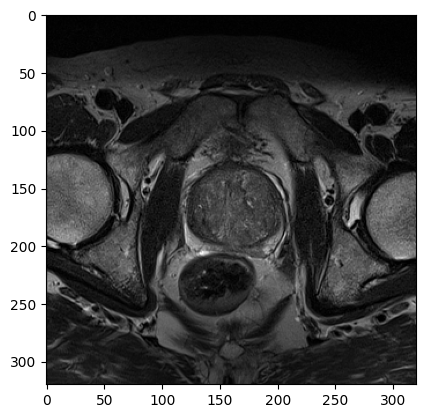

In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Load the image
image = sitk.ReadImage(mhd_file_path)

# Convert the image to a NumPy array (for display)
image_array = sitk.GetArrayFromImage(image)

# Visualize the slice_index slice
plt.imshow(image_array[10], cmap='gray')
plt.show()

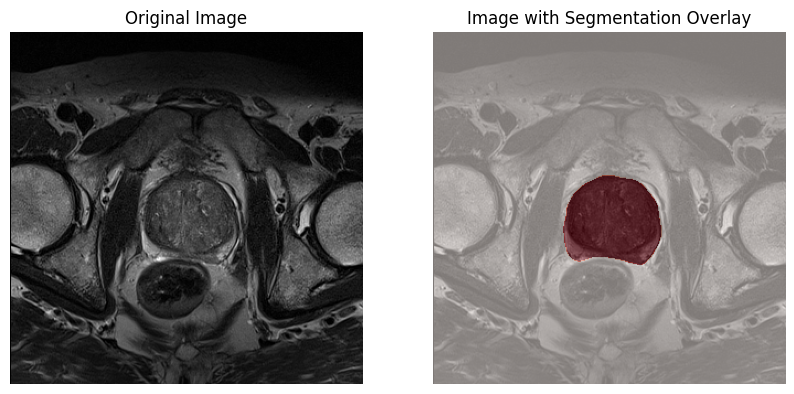

In [3]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os

def visualize_image_with_segmentation(image_path, segmentation_path, slice_index=0):
    # Load the image and segmentation
    image = sitk.ReadImage(image_path)
    segmentation = sitk.ReadImage(segmentation_path)

    # Convert to NumPy arrays
    image_array = sitk.GetArrayFromImage(image)
    segmentation_array = sitk.GetArrayFromImage(segmentation)

    # Extract the slice
    image_slice = image_array[slice_index]
    segmentation_slice = segmentation_array[slice_index]

    # Overlay visualization
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_slice, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Segmentation overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image_slice, cmap='gray')
    plt.imshow(segmentation_slice, alpha=0.5, cmap='Reds')  # Overlay in red
    plt.title("Image with Segmentation Overlay")
    plt.axis('off')

    plt.show()

# Example usage
visualize_image_with_segmentation(mhd_file_path, mhd_file_path[:-4] +"_segmentation.mhd", slice_index=10)


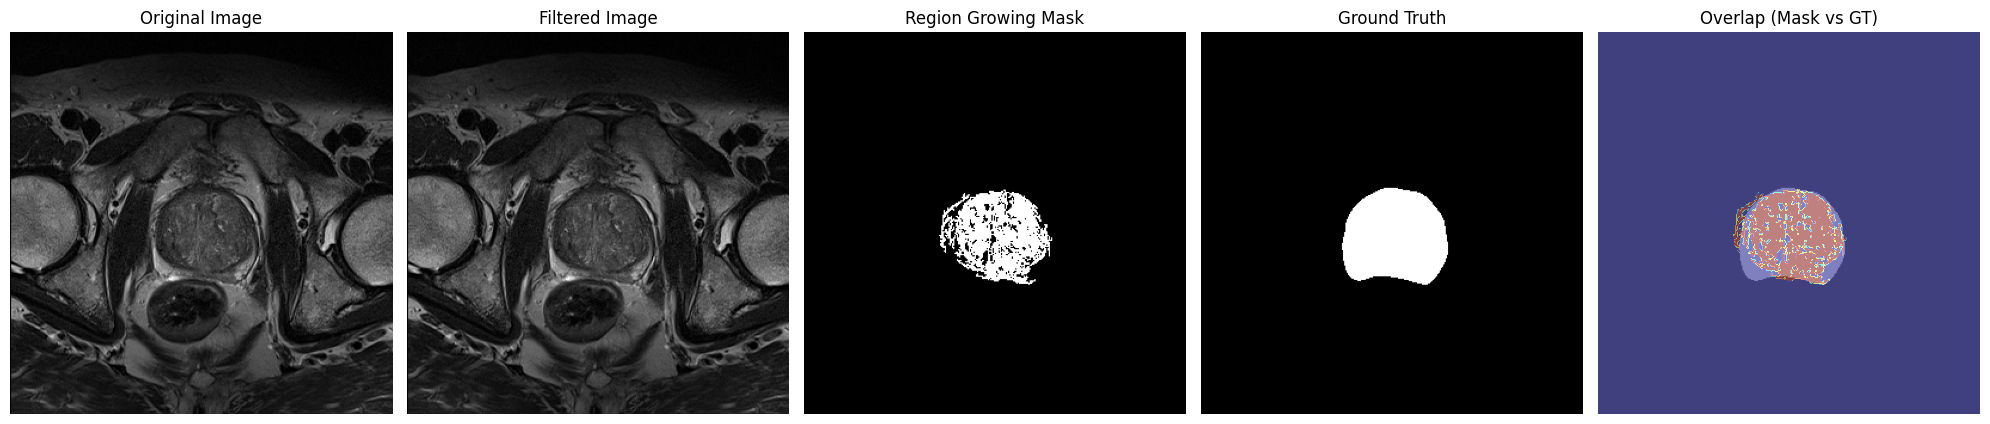

In [4]:
from region_growing import inspect_algorithm
a = inspect_algorithm(mhd_file_path, mhd_file_path[:-4] +"_segmentation.mhd", slice_index=10, pipeline='pipeline_2', threshold=100, save_figures=False)